In [1]:
import io
from pprint import pprint

import requests

import pydicom
import matplotlib.pyplot as plt
from pydicom import uid
from pydicom.filebase import DicomFileLike
from matplotlib.image import imread


def read_dicom_dataset(raw_data: bytes) -> pydicom.Dataset:
    """Permet de lire les bytes d'un fichier DICOM et le transformer en Dataset DICOM"""
    instance_uid = uid.generate_uid()
    buffer = io.BytesIO(raw_data)
    ds = pydicom.dcmread(buffer)

    return ds


def dicom_dataset_to_bytes(ds: pydicom.Dataset) -> io.BytesIO:
    """Permet d'écrire un Dataset DICOM en bytes"""
    buffer = io.BytesIO()
    memory_dataset = DicomFileLike(buffer)
    pydicom.dcmwrite(memory_dataset, ds)
    memory_dataset.seek(0)

    return buffer


def show_image_from_bytes(raw_data: bytes) -> None:
    buffer = io.BytesIO(raw_data)
    img = imread(buffer, format='png')

    plt.figure(figsize=(16, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


URL = 'http://172.17.0.2:5000'

# <center>API REST : accéder à des données et des fonctionnalités via le web</center>

<br>
<center>Gabriel Couture, Félix-Antoine Fortin, Olivier Chouinard-Banville</center>

## Mise en situation

- Vous êtes un stagiaire en physique médiale
- Vous devez évaluer la qualité de traitements de radiothérapie
- Pour ce faire : nous utilisons les histogrammes dose-volume (DVH)

## Radiothérapie : cours express

<br>
<center><img src="./imgs/flot-radiotherapie.png" style="width: 700px;"></center>
<br>
<center><img src="./imgs/radiotherapy.png" style="width: 500px;"></center>

## Radiothérapie : images
Acquisition d'images (ex. CT)

<br>
<center><img src="./imgs/phantom-thorax.png" style="width: 300px;"></center>

## Radiothérapie : contours
- Tracé de structure (organes/région d'intérêt)

<table border="0">
 <tr>
    <td><img src="./imgs/contours.png" style="height: 300px;"></td>
    <td><img src="./imgs/structure.png" style="height: 300px;"></td>
 </tr>
</table>

## Radiothérapie : cours express
- Planification de la dose

<center><img src="./imgs/dose-distribution.png" style="width: 600px;"></center>

## Radiothérapie : cours express
- Données impliquées
    - Images CT
        - Fichier DICOM de type "__CT__"
    - Structure (région/organe dessiné)
        - Fichier DICOM de type "__RTStruct__"
    - Carte de dose (array en 3D de la dose délivrée)
        - Fichier DICOM de type "__RTDose__"
<center><img src="./imgs/ct-struct-dose.gif" style="width: 100%;"></center>

## Comment évaluer la qualité du traitement?

- Construire un histogramme dose-volume (DVH)!

<center><img src="./imgs/dvh-process.png" style="width: 600px;"></center>
<center><img src="./imgs/dvh-diff-to-cumulative.png" style="width: 600px;"></center>

## Résultat final : un DVH!
- ~100% de la cible reçoit la dose de prescription
- Organes sensibles épargnés autant que possible

<br>
<center><img src="./imgs/dvh-exemple.png" style="width: 700px;"></center>

## Atelier : ce qui est à faire

- Une API REST vous est mise à disposition. À partir de celle-ci, vous pourrez :
    - Récupérer des données
    - Anonymiser des données
    - Calculer des DVH
    - Et plus!

<center><img src="./imgs/atelier.png" style="width: 1200px;"></center>

## Données à manipuler

- 3 fichiers RTStruct (cylindre, shpère, cone)
- 1 fichier RTDose
<table border="0">
 <tr>
    <td><img src="./imgs/cylinder.png" style="height: 250px;"></td>
    <td><img src="./imgs/sphere.png" style="height: 250px;"></td>
    <td><img src="./imgs/cone.png" style="height: 250px;"></td>
    <td><img src="./imgs/dose-workflow.png" style="height: 250px;"></td>
 </tr>
</table>
Source : https://doi.org/10.1118/1.4923175

## Librairie Python `requests`

```python
response = requests.get(url='http://<url>/<route>', params={'key': 'value'})
response = requests.post(
    url='http://<url>/<route>',
    data={'key': 'value'},          # Pour les valeurs (str, float ou int)
    files={'key': bytes},           # Pour des fichiers (sous forme de bytes)
    json={'key': {'key': 'value'}}) # Pour des dictionnaires ou listes
response = requests.put(
    url='http://<url>/<route>',
    data={'key': 'value'},           # ...
    files={'key': bytes},            # ...
    json={'key': {'key': 'value'}})  # ...
response = requests.delete(url='http://<url>/<route>', params={'key': 'value'})
```

## Valider la connexion

- Validez d'abord que vous pouvez interagir avec l'API REST.

In [2]:
response = requests.get(f'{URL}')
print(response.status_code)
pprint(response.json())

200
{'message': "Bonjour et bienvenue à l'atelier sur les API REST!"}


## 1. Création d'un compte
- Créez d'abord votre compte
- Pour créer un compte, faîtes un POST avec votre idul à la route `http://URL/account`
    - Vous pouvez soumettre votre idul de cette façon : `{'idul': 'votre-idul'}`

In [31]:
response = requests.post(f'{URL}/account', data={'idul': 'gacou42'})
print(response.status_code)
print(response.json())

201
{'message': 'created'}


## 2. Authentification

- Vous avez maintenant un compte, utilisez votre IDUL pour vous connecter!
- La route de l'API REST qui vous permet d'émettre un jeton d'authentification est `http://URL/auth`
- Soumettez votre idul via un POST afin d'émettre un jeton (token)
- Ce jeton vous permettra valider votre identiter par la suite

In [32]:
response = requests.post(f'{URL}/auth', data={'idul': 'gacou42'})
print(response.status_code)
print(response.json())

200
{'token': 'e2a2f3d81a0de2ba37bb821c9e16c7960e21cf84'}


## 3. Récupération des données
- Les données sont sous le format DICOM
- Vérifiez quelles données sont accessibles en les récupérant à `http://URL/data`
- Pour calculer un DVH, vous aurez besoin de r

In [33]:
TOKEN = 'e2a2f3d81a0de2ba37bb821c9e16c7960e21cf84'

response = requests.get(f'{URL}/data', params={'token': TOKEN})
print(response.json())

['sphere', 'cylinder', 'cone', 'dose']


In [41]:
response = requests.get(f'{URL}/data/sphere', params={'token': TOKEN})
sphere = util.read_dicom_dataset(response.content)
print(sphere.Modality, sphere.PatientName)

response = requests.get(f'{URL}/data/cylinder', params={'token': TOKEN})
cylinder = util.read_dicom_dataset(response.content)
print(cylinder.Modality, cylinder.PatientName)

response = requests.get(f'{URL}/data/cone', params={'token': TOKEN})
cone = util.read_dicom_dataset(response.content)
print(cone.Modality, cone.PatientName)

response = requests.get(f'{URL}/data/dose', params={'token': TOKEN})
dose = util.read_dicom_dataset(response.content)
print(dose.Modality, dose.PatientName)

RTSTRUCT Gabriel Couture
RTSTRUCT Gabriel Couture
RTSTRUCT Gabriel Couture
RTDOSE Gabriel Couture


## 4. Anonymisation des données

In [35]:
sphere_bytes = util.dicom_dataset_to_bytes(sphere)
response = requests.post(f'{URL}/anonymize', files={'file': sphere_bytes})
sphere = util.read_dicom_dataset(response.content)
print(sphere.PatientName)

cylinder_bytes = util.dicom_dataset_to_bytes(cylinder)
response = requests.post(f'{URL}/anonymize', files={'file': cylinder_bytes})
cylinder = util.read_dicom_dataset(response.content)
print(cylinder.PatientName)

cone_bytes = util.dicom_dataset_to_bytes(cone)
response = requests.post(f'{URL}/anonymize', files={'file': cone_bytes})
cone = util.read_dicom_dataset(response.content)
print(cone.PatientName)

dose_bytes = util.dicom_dataset_to_bytes(dose)
response = requests.post(f'{URL}/anonymize', files={'file': dose_bytes})
dose = util.read_dicom_dataset(response.content)
print(dose.PatientName)

^
^
^
^


## 5. Calcul des DVH

- POST à `http://URL/dvh` avec les fichiers `file_struct` et `file_dose` en bytes (utilisez `util.dicom_dataset_to_bytes`).

In [45]:
dvhs = {}

for name, struct in [('sphere', sphere), ('cylinder', cylinder), ('cone', cone)]:
    response = requests.post(
        f'{URL}/dvh',
        files={
            'file_struct': util.dicom_dataset_to_bytes(struct),
            'file_dose': util.dicom_dataset_to_bytes(dose)}
    )
    dvhs[name] = response.json()

## 6. Graphique des DVH

200


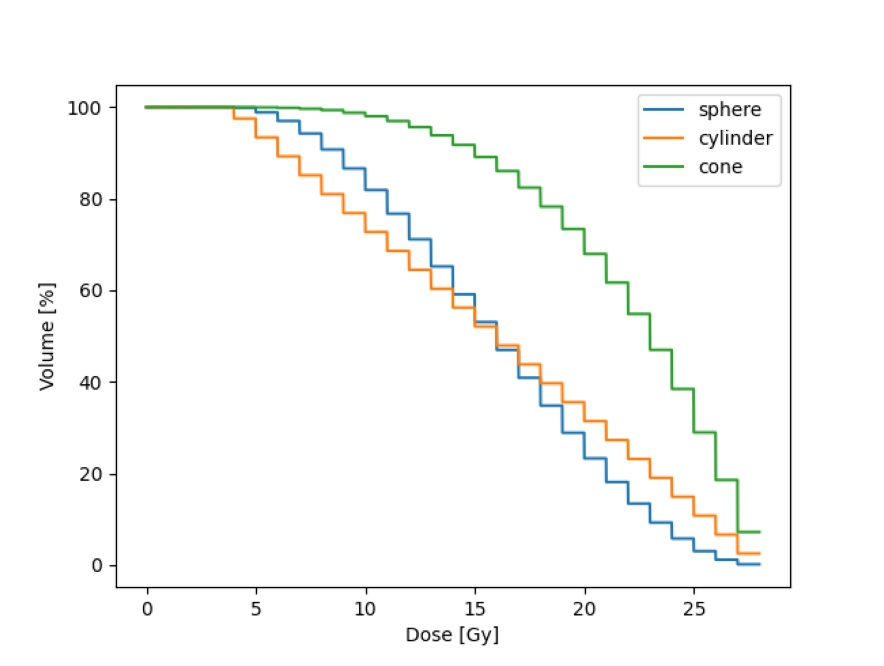

In [37]:
formated_dvhs = []
for name, dvh in dvhs.items():
    formated_dvhs.append({
        'name': name,
        'volumes': dvh[1]['volumes'],
        'doses': dvh[1]['doses'],
        'volume_units': dvh[1]['volume_units'],
        'dose_units': dvh[1]['dose_units']
    })
response = requests.post(
    f'{URL}/dvh/plot',
    json={'dvhs': formated_dvhs}
)
print(response.status_code)
util.show_image_from_bytes(response.content)